## QSPR на основе детерменированных цифровых представлений структуры

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Draw, AllChem, PandasTools, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import MolFromSmiles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


IPythonConsole.ipython_useSVG = True


мы возьмем QM9, датасет собранный и полученный вот тут https://arxiv.org/abs/1703.00564. Он содержит более 130 тысяч молекул, для которых при помощи инструментов квантовой химии рассчитаны различные энергетические характеристики (энергии HOMO и LUMO, колебательные постоянные, энтальпия и т.д.).

Внутри "сырых" данных есть два нужных нам файла - gdb9.sdf, где хранятся все структуры в sdf формате и gdb9.sdf.csv, где перечислены свойства соответствующих веществ. Организуем из этих файлов датасет:

In [14]:
df = pd.read_csv('QM9/raw/gdb9.sdf.csv')

In [15]:
new_df = PandasTools.LoadSDF('QM9/raw/gdb9.sdf', embedProps=True, molColName=None, smilesName='smiles')
#RDKit умеет корректно открывать sdf файлы, еще и превращать их в датафрейм со SMILES, если указать такие параметры в функции

[18:13:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:13:43] ERROR: Could not sanitize molecule ending on line 9097
[18:13:43] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[18:13:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:13:43] ERROR: Could not sanitize molecule ending on line 35785
[18:13:43] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[18:13:43] Explicit valence for atom # 4 C, 5, is greater than permitted
[18:13:43] ERROR: Could not sanitize molecule ending on line 62866
[18:13:43] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[18:13:43] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:13:43] ERROR: Could not sanitize molecule ending on line 66832
[18:13:43] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[18:13:43] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:13:43] ERROR: Could not sanitize molecule en

In [16]:
df


mol_id          A           B           C      mu  alpha    homo  \
0            gdb_1  157.71180  157.709970  157.706990  0.0000  13.21 -0.3877   
1            gdb_2  293.60975  293.541110  191.393970  1.6256   9.46 -0.2570   
2            gdb_3  799.58812  437.903860  282.945450  1.8511   6.31 -0.2928   
3            gdb_4    0.00000   35.610036   35.610036  0.0000  16.28 -0.2845   
4            gdb_5    0.00000   44.593883   44.593883  2.8937  12.99 -0.3604   
...            ...        ...         ...         ...     ...    ...     ...   
133880  gdb_133881    3.59483    2.198990    1.904230  1.6637  69.37 -0.2254   
133881  gdb_133882    3.65648    2.142370    1.904390  1.2976  69.52 -0.2393   
133882  gdb_133883    3.67118    2.143140    1.895010  1.2480  73.60 -0.2233   
133883  gdb_133884    3.52845    2.151310    1.865820  1.9576  77.40 -0.2122   
133884  gdb_133885    3.64015    2.217640    1.937930  0.8626  69.48 -0.2316   

          lumo     gap        r2      zpve          u0        u298  \
0       0.1171  0.5048   35.3641  0.044749  -40.478930  -40.476062   
1       0.0829  0.3399   26.1563  0.034358  -56.525887  -56.523026   
2       0.0687  0.3615   19.0002  0.021375  -76.404702  -76.401867   
3       0.0506  0.3351   59.5248  0.026841  -77.308427  -77.305527   
4       0.0191  0.3796   48.7476  0.016601  -93.411888  -93.409370   
...        ...     ...       ...       ...         ...         ...   
133880  0.0588  0.2842  760.7472  0.127406 -400.633868 -400.628599   
133881  0.0608  0.3002  762.6354  0.127495 -400.629713 -400.624444   
133882  0.0720  0.2953  780.3553  0.140458 -380.753918 -380.748619   
133883  0.0881  0.3003  803.1904  0.152222 -364.720374 -364.714974   
133884  0.0742  0.3058  756.3557  0.127862 -400.633052 -400.627892   

              h298        g298      cv      u0_atom    u298_atom    h298_atom  \
0       -40.475117  -40.498597   6.469  -395.999595  -398.643290  -401.014647   
1       -56.522082  -56.544961   6.316  -276.861363  -278.620271  -280.399259   
2       -76.400922  -76.422349   6.002  -213.087624  -213.974294  -215.159658   
3       -77.304583  -77.327429   8.574  -385.501997  -387.237686  -389.016047   
4       -93.408425  -93.431246   6.278  -301.820534  -302.906752  -304.091489   
...            ...         ...     ...          ...          ...          ...   
133880 -400.627654 -400.663098  23.658 -1603.983913 -1614.898804 -1623.788097   
133881 -400.623500 -400.658942  23.697 -1601.376613 -1612.291504 -1621.181424   
133882 -380.747675 -380.783148  23.972 -1667.045429 -1678.830048 -1688.312964   
133883 -364.714030 -364.749650  24.796 -1794.600439 -1807.210860 -1817.286772   
133884 -400.626948 -400.662186  23.434 -1603.471865 -1614.455155 -1623.345075   

          g298_atom  
0       -372.471772  
1       -259.338802  
2       -201.407171  
3       -365.800724  
4       -288.720028  
...             ...  
133880 -1492.819438  
133881 -1490.211511  
133882 -1549.143391  
133883 -1670.349892  
133884 -1492.247150  

[133885 rows x 20 columns]

In [17]:
new_df

ID                           smiles
0          gdb_1                                C
1          gdb_2                                N
2          gdb_3                                O
3          gdb_4                              C#C
4          gdb_5                              C#N
...          ...                              ...
17196  gdb_17197  O[C@H]1[C@H]2C[C@@H]1[C@@]21CN1
17197  gdb_17198  O[C@H]1[C@H]2C[C@@H]1[C@@]21CO1
17198  gdb_17199  O[C@H]1[C@H]2N[C@@H]1[C@@]21CN1
17199  gdb_17200  O[C@H]1[C@H]2N[C@@H]1[C@@]21CO1
17200  gdb_17201      O[C@H]1[C@H]2O[C@@H]1C21CC1

[17110 rows x 2 columns]

Теперь объединим эти два датафрейма. 

In [18]:
df = df.rename(columns={"mol_id": "ID"}) #переназовем столбец в df, чтобы название совпадало с new_df
df = pd.merge(df, new_df, on="ID") #корректно объединим датафреймы по столбцу с ID соединений
df
#и вот теперь у нас есть датасет, готовый к работе

ID          A           B           C      mu  alpha    homo  \
0          gdb_1  157.71180  157.709970  157.706990  0.0000  13.21 -0.3877   
1          gdb_2  293.60975  293.541110  191.393970  1.6256   9.46 -0.2570   
2          gdb_3  799.58812  437.903860  282.945450  1.8511   6.31 -0.2928   
3          gdb_4    0.00000   35.610036   35.610036  0.0000  16.28 -0.2845   
4          gdb_5    0.00000   44.593883   44.593883  2.8937  12.99 -0.3604   
...          ...        ...         ...         ...     ...    ...     ...   
17105  gdb_17197    4.99437    1.616980    1.455260  2.6622  68.84 -0.2368   
17106  gdb_17198    5.04660    1.619860    1.454840  0.3926  64.71 -0.2482   
17107  gdb_17199    5.20978    1.613400    1.454660  2.1194  65.19 -0.2395   
17108  gdb_17200    5.38472    1.610910    1.461450  1.4718  61.40 -0.2509   
17109  gdb_17201    5.15780    1.612480    1.446570  1.9012  65.32 -0.2489   

         lumo     gap        r2  ...          u0        u298        h298  \
0      0.1171  0.5048   35.3641  ...  -40.478930  -40.476062  -40.475117   
1      0.0829  0.3399   26.1563  ...  -56.525887  -56.523026  -56.522082   
2      0.0687  0.3615   19.0002  ...  -76.404702  -76.401867  -76.400922   
3      0.0506  0.3351   59.5248  ...  -77.308427  -77.305527  -77.304583   
4      0.0191  0.3796   48.7476  ...  -93.411888  -93.409370  -93.408425   
...       ...     ...       ...  ...         ...         ...         ...   
17105  0.0768  0.3136  886.5714  ... -363.768558 -363.761742 -363.760798   
17106  0.0639  0.3120  869.7515  ... -383.651076 -383.644337 -383.643392   
17107  0.0683  0.3078  869.7325  ... -379.806919 -379.800430 -379.799486   
17108  0.0728  0.3237  851.3391  ... -399.689693 -399.683307 -399.682362   
17109  0.0698  0.3187  880.4216  ... -383.641157 -383.634510 -383.633566   

             g298      cv      u0_atom    u298_atom    h298_atom    g298_atom  \
0      -40.498597   6.469  -395.999595  -398.643290  -401.014647  -372.471772   
1      -56.544961   6.316  -276.861363  -278.620271  -280.399259  -259.338802   
2      -76.422349   6.002  -213.087624  -213.974294  -215.159658  -201.407171   
3      -77.327429   8.574  -385.501997  -387.237686  -389.016047  -365.800724   
4      -93.431246   6.278  -301.820534  -302.906752  -304.091489  -288.720028   
...           ...     ...          ...          ...          ...          ...   
17105 -363.799103  27.469 -1592.008531 -1602.840591 -1612.324135 -1477.425387   
17106 -383.681613  26.846 -1530.558457 -1540.550283 -1549.440203 -1422.707858   
17107 -379.837253  26.232 -1467.476232 -1477.624308 -1486.514855 -1359.138058   
17108 -399.719977  25.500 -1406.186801 -1415.510957 -1423.807881 -1304.554815   
17109 -383.671649  26.769 -1524.334195 -1534.383752 -1543.274299 -1416.455358   

                                smiles  
0                                    C  
1                                    N  
2                                    O  
3                                  C#C  
4                                  C#N  
...                                ...  
17105  O[C@H]1[C@H]2C[C@@H]1[C@@]21CN1  
17106  O[C@H]1[C@H]2C[C@@H]1[C@@]21CO1  
17107  O[C@H]1[C@H]2N[C@@H]1[C@@]21CN1  
17108  O[C@H]1[C@H]2N[C@@H]1[C@@]21CO1  
17109      O[C@H]1[C@H]2O[C@@H]1C21CC1  

[17110 rows x 21 columns]

Пока что упростим себе задачу и будем воспринимать в качестве таргетов _alpha_, то бишь изотропную поляризуемость молекулы, _cv_ (молярную теплоемкость при постоянном объеме) и _gap_ (ширину запрещенной зоны). Отпечатки Моргана молекулы возьмем в качестве фичей.

In [19]:
target_df = df[['alpha', 'cv', 'gap']].copy()
smiles_df = df[['smiles']].copy()

In [20]:
smiles_df

smiles
0                                    C
1                                    N
2                                    O
3                                  C#C
4                                  C#N
...                                ...
17105  O[C@H]1[C@H]2C[C@@H]1[C@@]21CN1
17106  O[C@H]1[C@H]2C[C@@H]1[C@@]21CO1
17107  O[C@H]1[C@H]2N[C@@H]1[C@@]21CN1
17108  O[C@H]1[C@H]2N[C@@H]1[C@@]21CO1
17109      O[C@H]1[C@H]2O[C@@H]1C21CC1

[17110 rows x 1 columns]

Дополним SMILES-БД отпечатками Моргана в виде битного вектора. Данная БД будет выступать в качестве фичей алгоритма регрессии в дальнейших задачах

In [10]:
def generate_morgan_fingerprints(smiles, radius=2, nBits=2048):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        return np.array(fingerprint, dtype=np.uint8)
    except Exception:
        return None

def add_morgan_fingerprints_to_df(df, smiles_column='smiles', radius=2, nBits=2048, prefix='morgan_', chunk_size=1000):
    fp_columns = [f'{prefix}{i}' for i in range(nBits)]
    
    
    temp_file = 'fingerprints_chunked.csv'
    first_write = True
    
    for chunk_start in range(0, len(df), chunk_size):
        chunk = df.iloc[chunk_start:chunk_start + chunk_size]
        fingerprints = []
        
        for smiles in chunk[smiles_column]:
            fp = generate_morgan_fingerprints(smiles, radius=radius, nBits=nBits)
            if fp is None:
                fp = np.zeros(nBits, dtype=np.uint8)
            fingerprints.append(fp)
        
        fingerprints_array = np.array(fingerprints, dtype=np.uint8)
        fp_df = pd.DataFrame(fingerprints_array, columns=fp_columns)
        result_chunk = pd.concat([chunk.reset_index(drop=True), fp_df], axis=1)
        
        
        result_chunk.to_csv(temp_file, mode='a', index=False, header=first_write)
        first_write = False
        
        print(f"Processed chunk {chunk_start} to {chunk_start + len(chunk)}")
    
    print(f"Fingerprints saved to {temp_file}")
    return temp_file

print("Starting Morgan fingerprint generation...")
output_file = add_morgan_fingerprints_to_df(
    smiles_df,
    smiles_column='smiles',
    radius=2,
    nBits=2048,
    prefix='morgan_',
    chunk_size=1000  
)

print(f"Fingerprints saved to {output_file}")


Starting Morgan fingerprint generation...


[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerator
[14:46:12] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 0 to 1000


[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerator
[14:46:17] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 1000 to 2000


[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerator
[14:46:22] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 2000 to 3000


[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerator
[14:46:27] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 3000 to 4000


[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerator
[14:46:32] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 4000 to 5000


[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerator
[14:46:37] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 5000 to 6000


[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerator
[14:46:42] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 6000 to 7000


[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerator
[14:46:47] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 7000 to 8000


[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerator
[14:46:51] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 8000 to 9000


[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerator
[14:46:55] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 9000 to 10000


[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerator
[14:47:00] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 10000 to 11000


[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerator
[14:47:04] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 11000 to 12000


[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerator
[14:47:08] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 12000 to 13000


[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerator
[14:47:13] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 13000 to 14000


[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerator
[14:47:18] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 14000 to 15000


[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerator
[14:47:24] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 15000 to 16000


[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerator
[14:47:29] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 16000 to 17000


[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerator
[14:47:34] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 17000 to 18000


[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerator
[14:47:38] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 18000 to 19000


[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerator
[14:47:43] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 19000 to 20000


[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerator
[14:47:48] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 20000 to 21000


[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerator
[14:47:52] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 21000 to 22000


[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerator
[14:47:57] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 22000 to 23000


[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerator
[14:48:02] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 23000 to 24000


[14:48:05] DEPRECATION WARNING: please use MorganGenerator
[14:48:05] DEPRECATION WARNING: please use MorganGenerator
[14:48:05] DEPRECATION WARNING: please use MorganGenerator
[14:48:05] DEPRECATION WARNING: please use MorganGenerator
[14:48:05] DEPRECATION WARNING: please use MorganGenerator
[14:48:05] DEPRECATION WARNING: please use MorganGenerator
[14:48:05] DEPRECATION WARNING: please use MorganGenerator
[14:48:06] DEPRECATION WARNING: please use MorganGenerator
[14:48:06] DEPRECATION WARNING: please use MorganGenerator
[14:48:06] DEPRECATION WARNING: please use MorganGenerator
[14:48:06] DEPRECATION WARNING: please use MorganGenerator
[14:48:06] DEPRECATION WARNING: please use MorganGenerator
[14:48:06] DEPRECATION WARNING: please use MorganGenerator
[14:48:06] DEPRECATION WARNING: please use MorganGenerator
[14:48:06] DEPRECATION WARNING: please use MorganGenerator
[14:48:06] DEPRECATION WARNING: please use MorganGenerator
[14:48:06] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 24000 to 25000


[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerator
[14:48:10] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 25000 to 26000


[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerator
[14:48:15] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 26000 to 27000


[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerator
[14:48:20] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 27000 to 28000


[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerator
[14:48:26] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 28000 to 29000


[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerator
[14:48:31] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 29000 to 30000


[14:48:36] DEPRECATION WARNING: please use MorganGenerator
[14:48:36] DEPRECATION WARNING: please use MorganGenerator
[14:48:36] DEPRECATION WARNING: please use MorganGenerator
[14:48:36] DEPRECATION WARNING: please use MorganGenerator
[14:48:36] DEPRECATION WARNING: please use MorganGenerator
[14:48:36] DEPRECATION WARNING: please use MorganGenerator
[14:48:36] DEPRECATION WARNING: please use MorganGenerator
[14:48:36] DEPRECATION WARNING: please use MorganGenerator
[14:48:36] DEPRECATION WARNING: please use MorganGenerator
[14:48:36] DEPRECATION WARNING: please use MorganGenerator
[14:48:37] DEPRECATION WARNING: please use MorganGenerator
[14:48:37] DEPRECATION WARNING: please use MorganGenerator
[14:48:37] DEPRECATION WARNING: please use MorganGenerator
[14:48:37] DEPRECATION WARNING: please use MorganGenerator
[14:48:37] DEPRECATION WARNING: please use MorganGenerator
[14:48:37] DEPRECATION WARNING: please use MorganGenerator
[14:48:37] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 30000 to 31000


[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerator
[14:48:42] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 31000 to 32000


[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerator
[14:48:49] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 32000 to 33000


[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerator
[14:48:54] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 33000 to 34000


[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerator
[14:48:59] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 34000 to 35000


[14:49:03] DEPRECATION WARNING: please use MorganGenerator
[14:49:03] DEPRECATION WARNING: please use MorganGenerator
[14:49:03] DEPRECATION WARNING: please use MorganGenerator
[14:49:03] DEPRECATION WARNING: please use MorganGenerator
[14:49:03] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerator
[14:49:04] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 35000 to 36000


[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerator
[14:49:09] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 36000 to 37000


[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerator
[14:49:13] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 37000 to 38000


[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerator
[14:49:18] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 38000 to 39000


[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerator
[14:49:22] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 39000 to 40000


[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerator
[14:49:27] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 40000 to 41000


[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerator
[14:49:32] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 41000 to 42000


[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerator
[14:49:36] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 42000 to 43000


[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerator
[14:49:41] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 43000 to 44000


[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerator
[14:49:45] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 44000 to 45000


[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerator
[14:49:50] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 45000 to 46000


[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerator
[14:49:55] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 46000 to 47000


[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerator
[14:49:59] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 47000 to 48000


[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerator
[14:50:04] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 48000 to 49000


[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerator
[14:50:09] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 49000 to 50000


[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerator
[14:50:13] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 50000 to 51000


[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerator
[14:50:18] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 51000 to 52000


[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerator
[14:50:24] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 52000 to 53000


[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerator
[14:50:29] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 53000 to 54000


[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerator
[14:50:33] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 54000 to 55000


[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerator
[14:50:38] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 55000 to 56000


[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerator
[14:50:42] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 56000 to 57000


[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerator
[14:50:47] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 57000 to 58000


[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerator
[14:50:52] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 58000 to 59000


[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerator
[14:50:57] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 59000 to 60000


[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerator
[14:51:01] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 60000 to 61000


[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerator
[14:51:06] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 61000 to 62000


[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerator
[14:51:10] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 62000 to 63000


[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerator
[14:51:15] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 63000 to 64000


[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerator
[14:51:19] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 64000 to 65000


[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerator
[14:51:24] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 65000 to 66000


[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerator
[14:51:28] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 66000 to 67000


[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerator
[14:51:33] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 67000 to 68000


[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerator
[14:51:38] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 68000 to 69000


[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerator
[14:51:43] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 69000 to 70000


[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerator
[14:51:47] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 70000 to 71000


[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerator
[14:51:52] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 71000 to 72000


[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerator
[14:51:57] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 72000 to 73000


[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerator
[14:52:02] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 73000 to 74000


[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerator
[14:52:06] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 74000 to 75000


[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerator
[14:52:11] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 75000 to 76000


[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:15] DEPRECATION WARNING: please use MorganGenerator
[14:52:16] DEPRECATION WARNING: please use MorganGenerator
[14:52:16] DEPRECATION WARNING: please use MorganGenerator
[14:52:16] DEPRECATION WARNING: please use MorganGenerator
[14:52:16] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 76000 to 77000


[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerator
[14:52:20] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 77000 to 78000


[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerator
[14:52:25] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 78000 to 79000


[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerator
[14:52:29] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 79000 to 80000


[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerator
[14:52:34] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 80000 to 81000


[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerator
[14:52:39] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 81000 to 82000


[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerator
[14:52:43] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 82000 to 83000


[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerator
[14:52:48] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 83000 to 84000


[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerator
[14:52:52] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 84000 to 85000


[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerator
[14:52:57] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 85000 to 86000


[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerator
[14:53:01] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 86000 to 87000


[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerator
[14:53:05] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 87000 to 88000


[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerator
[14:53:10] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 88000 to 89000


[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerator
[14:53:15] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 89000 to 90000


[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerator
[14:53:19] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 90000 to 91000


[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerator
[14:53:24] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 91000 to 92000


[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerator
[14:53:28] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 92000 to 93000


[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerator
[14:53:33] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 93000 to 94000


[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerator
[14:53:38] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 94000 to 95000


[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerator
[14:53:43] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 95000 to 96000


[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerator
[14:53:48] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 96000 to 97000


[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerator
[14:53:53] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 97000 to 98000


[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerator
[14:53:58] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 98000 to 99000


[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerator
[14:54:03] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 99000 to 100000


[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerator
[14:54:07] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 100000 to 101000


[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerator
[14:54:12] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 101000 to 102000


[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerator
[14:54:17] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 102000 to 103000


[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerator
[14:54:21] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 103000 to 104000


[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerator
[14:54:26] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 104000 to 105000


[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerator
[14:54:31] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 105000 to 106000


[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerator
[14:54:36] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 106000 to 107000


[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerator
[14:54:40] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 107000 to 108000


[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerator
[14:54:45] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 108000 to 109000


[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerator
[14:54:50] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 109000 to 110000


[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerator
[14:54:55] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 110000 to 111000


[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerator
[14:55:00] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 111000 to 112000


[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerator
[14:55:04] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 112000 to 113000


[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerator
[14:55:08] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 113000 to 114000


[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerator
[14:55:13] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 114000 to 115000


[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerator
[14:55:18] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 115000 to 116000


[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerator
[14:55:23] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 116000 to 117000


[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerator
[14:55:28] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 117000 to 118000


[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerator
[14:55:32] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 118000 to 119000


[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerator
[14:55:37] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 119000 to 120000


[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerator
[14:55:42] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 120000 to 121000


[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerator
[14:55:47] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 121000 to 122000


[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerator
[14:55:51] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 122000 to 123000


[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerator
[14:55:56] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 123000 to 124000


[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerator
[14:56:01] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 124000 to 125000


[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerator
[14:56:06] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 125000 to 126000


[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerator
[14:56:11] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 126000 to 127000


[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerator
[14:56:15] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 127000 to 128000


[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerator
[14:56:20] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 128000 to 129000


[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerator
[14:56:25] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 129000 to 130000


[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerator
[14:56:30] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 130000 to 131000


[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerator
[14:56:35] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 131000 to 132000


[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerator
[14:56:39] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 132000 to 133000


[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerator
[14:56:44] DEPRECATION WARNING: please use MorganGenerat

Processed chunk 133000 to 133247
Fingerprints saved to fingerprints_chunked.csv
Fingerprints saved to fingerprints_chunked.csv


Я разделил датасет на чанки и сохранил в отдельном csv файле для облегчения вычислений


In [21]:
smiles_df

smiles
0                                    C
1                                    N
2                                    O
3                                  C#C
4                                  C#N
...                                ...
17105  O[C@H]1[C@H]2C[C@@H]1[C@@]21CN1
17106  O[C@H]1[C@H]2C[C@@H]1[C@@]21CO1
17107  O[C@H]1[C@H]2N[C@@H]1[C@@]21CN1
17108  O[C@H]1[C@H]2N[C@@H]1[C@@]21CO1
17109      O[C@H]1[C@H]2O[C@@H]1C21CC1

[17110 rows x 1 columns]

In [22]:
smiles_df_with_fingerprints =  pd.read_csv('fingerprints_chunked.csv')

print(smiles_df_with_fingerprints.head())


  smiles  morgan_0  morgan_1  morgan_2  morgan_3  morgan_4  morgan_5  \
0      C         0         0         0         0         0         0   
1      N         0         0         0         0         0         0   
2      O         0         0         0         0         0         0   
3    C#C         0         0         0         0         0         0   
4    C#N         0         0         0         0         0         0   

   morgan_6  morgan_7  morgan_8  ...  morgan_2038  morgan_2039  morgan_2040  \
0         0         0         0  ...            0            0            0   
1         0         0         0  ...            0            0            0   
2         0         0         0  ...            0            0            0   
3         0         0         0  ...            0            0            0   
4         0         0         0  ...            0            0            0   

   morgan_2041  morgan_2042  morgan_2043  morgan_2044  morgan_2045  \
0            0        

Для начала проверим полезность сжатия PCA для задач в QSPR, зафиксируем random_state для воспроизводимости результатов. Использовать будем линейную регрессию.

In [23]:
target_df


alpha      cv     gap
0      13.21   6.469  0.5048
1       9.46   6.316  0.3399
2       6.31   6.002  0.3615
3      16.28   8.574  0.3351
4      12.99   6.278  0.3796
...      ...     ...     ...
17105  68.84  27.469  0.3136
17106  64.71  26.846  0.3120
17107  65.19  26.232  0.3078
17108  61.40  25.500  0.3237
17109  65.32  26.769  0.3187

[17110 rows x 3 columns]

Разобьем наш датафрейм на train и test 

In [14]:
# Создаем категории для столбца alpha для обеспечения стратифицированного разбиения
# Используем квантили, чтобы добиться равномерного распределения значений
# по сути делаем разбиение на тестовые и тренировочные данные более равномерно
target_df['alpha_cat'] = pd.qcut(target_df['alpha'], q=10, labels=False)

# Делим данные на тренировочный и тестовый наборы
train_df, test_df = train_test_split(
    target_df,
    test_size=0.2,  
    random_state=40,  # Фиксируем случайность для воспроизводимости
    stratify=target_df['alpha_cat']  
)

# Удаляем временный столбец, созданный для стратификации
train_df = train_df.drop(columns='alpha_cat')
test_df = test_df.drop(columns='alpha_cat')

# Отображаем размеры тренировочного и тестового наборов
print("Размер тренировочного набора:", len(train_df))
print("Размер тестового набора:", len(test_df))

# Анализируем распределение значений alpha в обоих наборах
print("\nАнализ alpha в тренировочном наборе:")
print(train_df['alpha'].describe())
print("\nАнализ alpha в тестовом наборе:")
print(test_df['alpha'].describe())


Размер тренировочного набора: 106597
Размер тестового набора: 26650

Анализ alpha в тренировочном наборе:
count    106597.000000
mean         75.189370
std           8.205917
min           6.310000
25%          70.380000
50%          75.510000
75%          80.530000
max         196.620000
Name: alpha, dtype: float64

Анализ alpha в тестовом наборе:
count    26650.000000
mean        75.219994
std          8.155772
min         16.970000
25%         70.380000
50%         75.510000
75%         80.530000
max        127.460000
Name: alpha, dtype: float64


In [15]:
train_df

alpha      cv     gap
92387   79.81  35.500  0.2661
126870  70.88  28.793  0.1584
46129   87.58  30.989  0.1995
58594   82.01  36.789  0.2923
107250  75.50  29.768  0.2308
...       ...     ...     ...
87437   76.58  33.254  0.2621
91650   73.00  31.419  0.2813
58313   87.77  38.932  0.3162
119893  81.26  34.198  0.2934
125715  77.05  30.817  0.1650

[106597 rows x 3 columns]

In [27]:
# Устанавливаем фиксированные параметры для воспроизводимости эксперимента
RANDOM_SEED = 40
TEST_SIZE = 0.2
PCA_VARIANCE = 0.95

# Добавляем категориальный столбец для alpha, чтобы обеспечить стратификацию при разбиении
target_df['alpha_cat'] = pd.qcut(target_df['alpha'], q=10, labels=False)

# Создаем копию исходного DataFrame, включая вспомогательный столбец alpha_cat
target_df_with_alpha_cat = target_df.copy()

# 1. Обработка данных без применения PCA
# Выбираем только признаки, представляющие собой отпечатки
morgan_columns = [col for col in smiles_df_with_fingerprints.columns if col.startswith('morgan_')]
X = smiles_df_with_fingerprints[morgan_columns]
y = target_df[['alpha', 'cv', 'gap']]

# Разбиваем данные на тренировочные и тестовые наборы без PCA
X_train_no_pca, X_test_no_pca, y_train_no_pca, y_test_no_pca = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=target_df['alpha_cat']
)

# 2. Обработка данных с применением PCA
# Приводим данные к стандартному масштабу
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Применяем PCA для уменьшения размерности данных
pca = PCA(n_components=PCA_VARIANCE, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_scaled)

# Создаем DataFrame для PCA-компонент
pca_columns = [f'PC_{i+1}' for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns)

# Разбиваем данные на тренировочные и тестовые наборы после применения PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_df, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=target_df['alpha_cat']
)

# Выводим информацию о размерах наборов данных
print("Наборы данных без применения PCA:")
print(f"Размер тренировочного набора: {X_train_no_pca.shape}")
print(f"Размер тестового набора: {X_test_no_pca.shape}")

print("\nНаборы данных после применения PCA:")
print(f"Размер тренировочного набора: {X_train_pca.shape}")
print(f"Размер тестового набора: {X_test_pca.shape}")
print(f"Процент сохраненной дисперсии: {100 * sum(pca.explained_variance_ratio_):.2f}%")

# Удаляем временный столбец alpha_cat из основного DataFrame
target_df = target_df.drop(columns='alpha_cat')


Наборы данных без применения PCA:
Размер тренировочного набора: (13688, 2048)
Размер тестового набора: (3422, 2048)

Наборы данных после применения PCA:
Размер тренировочного набора: (13688, 1703)
Размер тестового набора: (3422, 1703)
Процент сохраненной дисперсии: 95.00%


Копию датафрейма с alpha_cat мы сохранили для последующего использования.


In [ ]:
X_train_no_pca

In [ ]:
X_train_pca


Начало обучения модели для параметра: alpha

Результаты для alpha:
Без PCA:
R² (обучение): 0.6934
R² (тест): 0.6754
MSE (тест): 21.5918
MAE (тест): 3.4135

С PCA:
R² (обучение): 0.5722
R² (тест): 0.5595
MSE (тест): 29.2974
MAE (тест): 3.8615

Начало обучения модели для параметра: cv

Результаты для cv:
Без PCA:
R² (обучение): 0.7606
R² (тест): 0.7471
MSE (тест): 4.1863
MAE (тест): 1.5070

С PCA:
R² (обучение): 0.6779
R² (тест): 0.6728
MSE (тест): 5.4168
MAE (тест): 1.6904

Начало обучения модели для параметра: gap

Результаты для gap:
Без PCA:
R² (обучение): 0.8233
R² (тест): 0.8182
MSE (тест): 0.0004
MAE (тест): 0.0154

С PCA:
R² (обучение): 0.7891
R² (тест): 0.7829
MSE (тест): 0.0005
MAE (тест): 0.0169


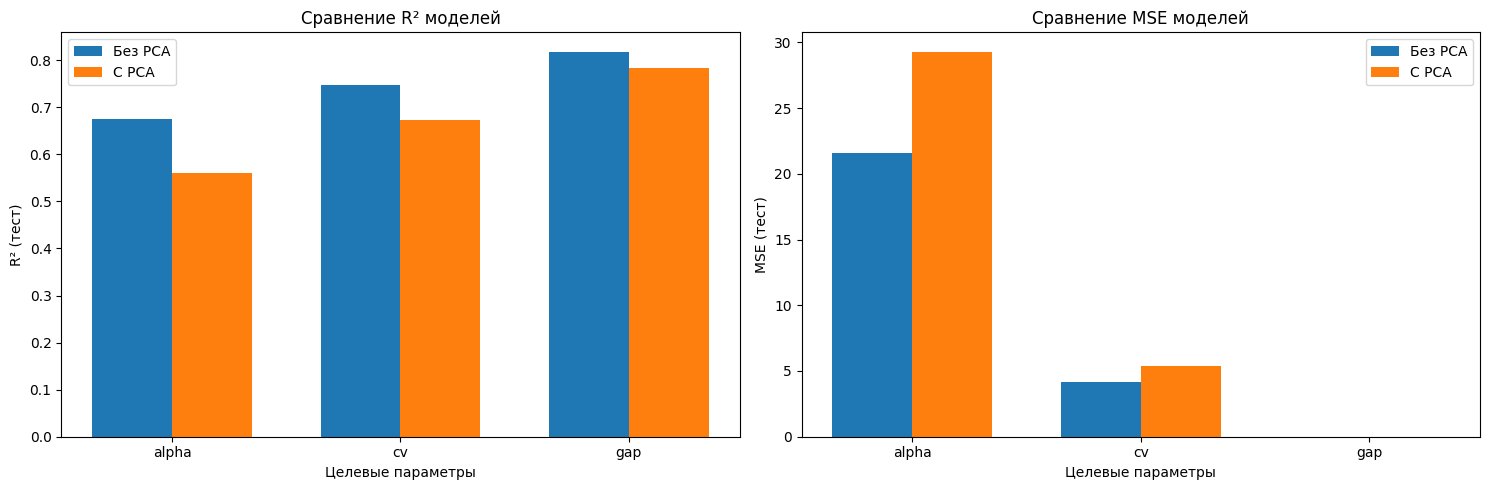

In [35]:

# Функция для обучения модели и оценки качества предсказаний
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Получение предсказаний
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Расчет метрик
    metrics = {
        'r2_train': r2_score(y_train, y_pred_train),
        'r2_test': r2_score(y_test, y_pred_test),
        'mse_train': mean_squared_error(y_train, y_pred_train),
        'mse_test': mean_squared_error(y_test, y_pred_test),
        'mae_train': mean_absolute_error(y_train, y_pred_train),
        'mae_test': mean_absolute_error(y_test, y_pred_test)
    }
    
    return model, metrics

# Словарь для сохранения результатов по всем моделям
results = {
    'no_pca': {},
    'with_pca': {}
}

# Целевые переменные для обучения моделей
target_names = ['alpha', 'cv', 'gap']

# Итерация по каждому целевому параметру
for target in target_names:
    print(f"\nНачало обучения модели для параметра: {target}")
    
    # Обучение и оценка модели без использования PCA
    y_train = y_train_no_pca[target]
    y_test = y_test_no_pca[target]
    
    model_no_pca, metrics_no_pca = train_and_evaluate(
        X_train_no_pca, X_test_no_pca, y_train, y_test
    )
    results['no_pca'][target] = metrics_no_pca
    
    # Обучение и оценка модели с применением PCA
    y_train = y_train_pca[target]
    y_test = y_test_pca[target]
    
    model_pca, metrics_pca = train_and_evaluate(
        X_train_pca, X_test_pca, y_train, y_test
    )
    results['with_pca'][target] = metrics_pca
    
    # Отображение метрик для текущей целевой переменной
    print(f"\nРезультаты для {target}:")
    print("Без PCA:")
    print(f"R² (обучение): {metrics_no_pca['r2_train']:.4f}")
    print(f"R² (тест): {metrics_no_pca['r2_test']:.4f}")
    print(f"MSE (тест): {metrics_no_pca['mse_test']:.4f}")
    print(f"MAE (тест): {metrics_no_pca['mae_test']:.4f}")
    
    print("\nС PCA:")
    print(f"R² (обучение): {metrics_pca['r2_train']:.4f}")
    print(f"R² (тест): {metrics_pca['r2_test']:.4f}")
    print(f"MSE (тест): {metrics_pca['mse_test']:.4f}")
    print(f"MAE (тест): {metrics_pca['mae_test']:.4f}")

# Визуализация метрик для моделей без PCA и с PCA
plt.figure(figsize=(15, 5))

# Визуализация R² для тестовых данных
plt.subplot(1, 2, 1)
x = np.arange(len(target_names))
width = 0.35

r2_no_pca = [results['no_pca'][target]['r2_test'] for target in target_names]
r2_pca = [results['with_pca'][target]['r2_test'] for target in target_names]

plt.bar(x - width/2, r2_no_pca, width, label='Без PCA')
plt.bar(x + width/2, r2_pca, width, label='С PCA')

plt.xlabel('Целевые параметры')
plt.ylabel('R² (тест)')
plt.title('Сравнение R² моделей')
plt.xticks(x, target_names)
plt.legend()

# Визуализация MSE для тестовых данных
plt.subplot(1, 2, 2)
mse_no_pca = [results['no_pca'][target]['mse_test'] for target in target_names]
mse_pca = [results['with_pca'][target]['mse_test'] for target in target_names]

plt.bar(x - width/2, mse_no_pca, width, label='Без PCA')
plt.bar(x + width/2, mse_pca, width, label='С PCA')

plt.xlabel('Целевые параметры')
plt.ylabel('MSE (тест)')
plt.title('Сравнение MSE моделей')
plt.xticks(x, target_names)
plt.legend()

plt.tight_layout()
plt.show()


По всем параметрам видно, что сжатие датасета с отпечатками Моргана приводит к ухудшению результатов нашей модели, что позволяет нам сделать вывод о том что PCA в данном варианте использования не несет практической выгоды.

Проведите аналогичный анализ, пользуясь альтернативным способом представления SMILES - в виде дескрипторов RDKit и/или Mordred (см код Descriptors and FPs). 

In [37]:
# Функция для расчета RDKit-дескрипторов
def generate_rdkit_descriptors(smiles):
    mol = MolFromSmiles(smiles)
    if mol is None:
        print(f"Неверный SMILES: {smiles}")
        return None
    
    descriptor_values = []
    for name, func in Descriptors.descList:
        try:
            value = func(mol)
        except Exception as e:
            value = np.nan  
        descriptor_values.append(value)
    
    return descriptor_values

def add_rdkit_descriptors_to_df(df, smiles_column='smiles'):
 
    descriptor_names = [name for name, _ in Descriptors.descList]
    descriptor_data = []

    for i, smiles in enumerate(df[smiles_column]):
        desc = generate_rdkit_descriptors(smiles)
        if desc is None:
            desc = [np.nan] * len(descriptor_names)  
        descriptor_data.append(desc)
        
        if i % 100 == 0:  # Выводим статус обработки каждые 100 молекул
            print(f"Обработано {i}/{len(df)} молекул")

    descriptor_df = pd.DataFrame(descriptor_data, columns=descriptor_names)
    return pd.concat([df.reset_index(drop=True), descriptor_df], axis=1)


smiles_df_with_descriptors = add_rdkit_descriptors_to_df(smiles_df)


print(smiles_df_with_descriptors.head())

Обработано 0/133247 молекул
Обработано 100/133247 молекул
Обработано 200/133247 молекул
Обработано 300/133247 молекул
Обработано 400/133247 молекул
Обработано 500/133247 молекул
Обработано 600/133247 молекул
Обработано 700/133247 молекул
Обработано 800/133247 молекул
Обработано 900/133247 молекул
Обработано 1000/133247 молекул
Обработано 1100/133247 молекул
Обработано 1200/133247 молекул
Обработано 1300/133247 молекул
Обработано 1400/133247 молекул
Обработано 1500/133247 молекул
Обработано 1600/133247 молекул
Обработано 1700/133247 молекул
Обработано 1800/133247 молекул
Обработано 1900/133247 молекул
Обработано 2000/133247 молекул
Обработано 2100/133247 молекул
Обработано 2200/133247 молекул
Обработано 2300/133247 молекул
Обработано 2400/133247 молекул
Обработано 2500/133247 молекул
Обработано 2600/133247 молекул
Обработано 2700/133247 молекул
Обработано 2800/133247 молекул
Обработано 2900/133247 молекул
Обработано 3000/133247 молекул
Обработано 3100/133247 молекул
Обработано 3200/1332

In [38]:
# Генерация дескрипторов RDKit
print("Starting RDKit descriptor generation...")
smiles_df_with_descriptors = add_rdkit_descriptors_to_df(smiles_df, smiles_column='smiles')

smiles_df_with_descriptors = smiles_df_with_descriptors.dropna(axis=1)

print(f"Original DataFrame shape: {smiles_df.shape}")
print(f"DataFrame with RDKit descriptors shape: {smiles_df_with_descriptors.shape}")


Starting RDKit descriptor generation...
Обработано 0/133247 молекул
Обработано 100/133247 молекул
Обработано 200/133247 молекул
Обработано 300/133247 молекул
Обработано 400/133247 молекул
Обработано 500/133247 молекул
Обработано 600/133247 молекул
Обработано 700/133247 молекул
Обработано 800/133247 молекул
Обработано 900/133247 молекул
Обработано 1000/133247 молекул
Обработано 1100/133247 молекул
Обработано 1200/133247 молекул
Обработано 1300/133247 молекул
Обработано 1400/133247 молекул
Обработано 1500/133247 молекул
Обработано 1600/133247 молекул
Обработано 1700/133247 молекул
Обработано 1800/133247 молекул
Обработано 1900/133247 молекул
Обработано 2000/133247 молекул
Обработано 2100/133247 молекул
Обработано 2200/133247 молекул
Обработано 2300/133247 молекул
Обработано 2400/133247 молекул
Обработано 2500/133247 молекул
Обработано 2600/133247 молекул
Обработано 2700/133247 молекул
Обработано 2800/133247 молекул
Обработано 2900/133247 молекул
Обработано 3000/133247 молекул
Обработано 

In [41]:

X_train_no_pca, X_test_no_pca, y_train_no_pca, y_test_no_pca = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=target_df_with_alpha_cat['alpha_cat']
)

# Сохранение индексов
train_indices = X_train_no_pca.index
test_indices = X_test_no_pca.index

# Генерация дескрипторов RDKit
smiles_df_with_descriptors = add_rdkit_descriptors_to_df(smiles_df, smiles_column='smiles')

# Удаление признаков с NaN
smiles_df_with_descriptors = smiles_df_with_descriptors.dropna(axis=1)

# Разделение дескрипторов
descriptor_names = [name for name, _ in Descriptors.descList]
X_train_descriptors = smiles_df_with_descriptors.loc[train_indices, descriptor_names]
X_test_descriptors = smiles_df_with_descriptors.loc[test_indices, descriptor_names]

# Целевые переменные
y_train_descriptors = y.loc[train_indices]
y_test_descriptors = y.loc[test_indices]


Обработано 0/133247 молекул
Обработано 100/133247 молекул
Обработано 200/133247 молекул
Обработано 300/133247 молекул
Обработано 400/133247 молекул
Обработано 500/133247 молекул
Обработано 600/133247 молекул
Обработано 700/133247 молекул
Обработано 800/133247 молекул
Обработано 900/133247 молекул
Обработано 1000/133247 молекул
Обработано 1100/133247 молекул
Обработано 1200/133247 молекул
Обработано 1300/133247 молекул
Обработано 1400/133247 молекул
Обработано 1500/133247 молекул
Обработано 1600/133247 молекул
Обработано 1700/133247 молекул
Обработано 1800/133247 молекул
Обработано 1900/133247 молекул
Обработано 2000/133247 молекул
Обработано 2100/133247 молекул
Обработано 2200/133247 молекул
Обработано 2300/133247 молекул
Обработано 2400/133247 молекул
Обработано 2500/133247 молекул
Обработано 2600/133247 молекул
Обработано 2700/133247 молекул
Обработано 2800/133247 молекул
Обработано 2900/133247 молекул
Обработано 3000/133247 молекул
Обработано 3100/133247 молекул
Обработано 3200/1332

In [42]:
# Отбор лучших признаков
selector = SelectKBest(score_func=f_regression, k=50)
X_train_selected = selector.fit_transform(X_train_descriptors, y_train)
X_test_selected = selector.transform(X_test_descriptors)


In [43]:
# Проверка данных
print("Размерности входных данных:")
print(f"X_train_descriptors: {X_train_descriptors.shape}")
print(f"X_test_descriptors: {X_test_descriptors.shape}")
print(f"y_train_descriptors: {y_train_descriptors.shape}")
print(f"y_test_descriptors: {y_test_descriptors.shape}")

# Проверка на отсутствие NaN
print("Проверка на NaN:")
print(f"X_train_descriptors NaN: {X_train_descriptors.isna().sum().sum()}")
print(f"X_test_descriptors NaN: {X_test_descriptors.isna().sum().sum()}")
print(f"y_train_descriptors NaN: {y_train_descriptors.isna().sum().sum()}")
print(f"y_test_descriptors NaN: {y_test_descriptors.isna().sum().sum()}")

Размерности входных данных:
X_train_descriptors: (106597, 210)
X_test_descriptors: (26650, 210)
y_train_descriptors: (106597, 3)
y_test_descriptors: (26650, 3)
Проверка на NaN:
X_train_descriptors NaN: 0
X_test_descriptors NaN: 0
y_train_descriptors NaN: 0
y_test_descriptors NaN: 0


In [44]:
def train_and_evaluate_multi(X_train, X_test, y_train, y_test):
    # Создаем отдельные модели для каждой целевой переменной
    models = {}
    metrics = {'r2_train': {}, 'r2_test': {}, 'mse_train': {}, 'mse_test': {}, 'mae_train': {}, 'mae_test': {}}
    
    # Стандартизация признаков
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Для каждой целевой переменной
    for target in y_train.columns:
        # Обучаем модель
        model = LinearRegression()
        model.fit(X_train_scaled, y_train[target])
        models[target] = model
        
        # Предсказания
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        
        # Метрики
        metrics['r2_train'][target] = r2_score(y_train[target], y_pred_train)
        metrics['r2_test'][target] = r2_score(y_test[target], y_pred_test)
        metrics['mse_train'][target] = mean_squared_error(y_train[target], y_pred_train)
        metrics['mse_test'][target] = mean_squared_error(y_test[target], y_pred_test)
        metrics['mae_train'][target] = mean_absolute_error(y_train[target], y_pred_train)
        metrics['mae_test'][target] = mean_absolute_error(y_test[target], y_pred_test)
    
    return models, metrics, scaler  # Возвращаем только эти 3 значения

# Использование новой функции:
models_descriptors, metrics_descriptors, scaler = train_and_evaluate_multi(
    X_train_descriptors, 
    X_test_descriptors, 
    y_train_descriptors, 
    y_test_descriptors
)

print("Результаты с RDKit-дескрипторами:")
for target in y_train_descriptors.columns:
    print(f"Метрики для {target}:")
    print(f"R² (train): {metrics_descriptors['r2_train'][target]:.4f}")
    print(f"R² (test): {metrics_descriptors['r2_test'][target]:.4f}")


Результаты с RDKit-дескрипторами:
Метрики для alpha:
R² (train): 0.9730
R² (test): -691382995253.7631
Метрики для cv:
R² (train): 0.9883
R² (test): -742077599922.2500
Метрики для gap:
R² (train): 0.8664
R² (test): -56336937049.8209


Мы столкнулись с переобучением из-за массивности и многомерности данных, проверим как себя будет вести модель на сжатых данных

Без PCA: тренировочный набор: (106597, 210), тестовый набор: (26650, 210)
С PCA: тренировочный набор: (106597, 10), тестовый набор: (26650, 10)

Обучение для alpha:
Без PCA - R² (test): -5748229.7403, MSE (test): 382338524.7108
С PCA - R² (test): 0.8976, MSE (test): 6.8111

Обучение для cv:
Без PCA - R² (test): -3217537.9534, MSE (test): 53261838.0601
С PCA - R² (test): 0.8831, MSE (test): 1.9347

Обучение для gap:
Без PCA - R² (test): -4525082.7080, MSE (test): 10241.3765
С PCA - R² (test): 0.5923, MSE (test): 0.0009


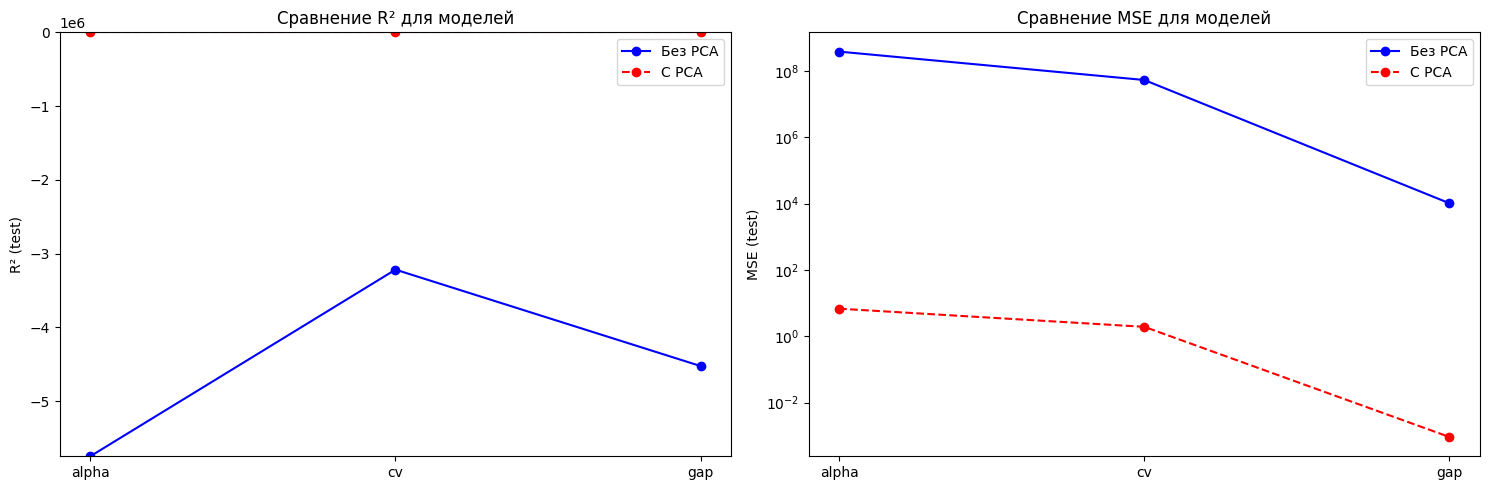

In [53]:
# Подготовка входных данных
X = smiles_df_with_descriptors.drop(columns=['smiles'])  # Исключаем столбец smiles
y = target_df_with_alpha_cat[['alpha', 'cv', 'gap']]  # Целевая переменная (alpha, cv, gap)

# Разделение данных без применения PCA
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=target_df_with_alpha_cat['alpha_cat']
)

# Стандартизация данных и применение PCA
X_scaled = StandardScaler().fit_transform(X)  # Применяем стандартизацию
X_pca = PCA(n_components=0.50, random_state=RANDOM_SEED).fit_transform(X_scaled)  # Применяем PCA для уменьшения размерности

# Разделение данных после применения PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=target_df_with_alpha_cat['alpha_cat']
)

# Вывод размеров тренировочных и тестовых наборов
print(f"Без PCA: тренировочный набор: {X_train.shape}, тестовый набор: {X_test.shape}")
print(f"С PCA: тренировочный набор: {X_train_pca.shape}, тестовый набор: {X_test_pca.shape}")

# Функция для обучения модели и оценки ее качества
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = LinearRegression()  # Используем линейную регрессию
    model.fit(X_train, y_train)  # Обучение модели
    
    # Прогнозирование значений
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Рассчитываем метрики для оценки качества модели
    return {
        'r2_train': r2_score(y_train, y_pred_train),
        'r2_test': r2_score(y_test, y_pred_test),
        'mse_train': mean_squared_error(y_train, y_pred_train),
        'mse_test': mean_squared_error(y_test, y_pred_test),
        'mae_train': mean_absolute_error(y_train, y_pred_train),
        'mae_test': mean_absolute_error(y_test, y_pred_test)
    }

# Словарь для хранения результатов
results = { 'no_pca': {}, 'with_pca': {} }

# Обучение моделей и сбор метрик для каждой целевой переменной
for target in ['alpha', 'cv', 'gap']:
    print(f"\nОбучение для {target}:")
    
    # Обучение модели без применения PCA
    metrics_no_pca = train_and_evaluate(X_train, X_test, y_train[target], y_test[target])
    results['no_pca'][target] = metrics_no_pca
    
    # Обучение модели с применением PCA
    metrics_pca = train_and_evaluate(X_train_pca, X_test_pca, y_train_pca[target], y_test_pca[target])
    results['with_pca'][target] = metrics_pca
    
    # Вывод результатов обучения
    print(f"Без PCA - R² (test): {metrics_no_pca['r2_test']:.4f}, MSE (test): {metrics_no_pca['mse_test']:.4f}")
    print(f"С PCA - R² (test): {metrics_pca['r2_test']:.4f}, MSE (test): {metrics_pca['mse_test']:.4f}")


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Визуализация R²
r2_no_pca = [results['no_pca'][target]['r2_test'] for target in ['alpha', 'cv', 'gap']]
r2_pca = [results['with_pca'][target]['r2_test'] for target in ['alpha', 'cv', 'gap']]
targets = ['alpha', 'cv', 'gap']

# Линейный график для R²
axes[0].plot(targets, r2_no_pca, marker='o', linestyle='-', color='b', label='Без PCA')
axes[0].plot(targets, r2_pca, marker='o', linestyle='--', color='r', label='С PCA')
axes[0].set_title('Сравнение R² для моделей')
axes[0].set_ylabel('R² (test)')
axes[0].set_ylim([min(min(r2_no_pca), min(r2_pca)) - 1, max(max(r2_no_pca), max(r2_pca)) + 1])
axes[0].legend()

# Визуализация MSE
mse_no_pca = [results['no_pca'][target]['mse_test'] for target in ['alpha', 'cv', 'gap']]
mse_pca = [results['with_pca'][target]['mse_test'] for target in ['alpha', 'cv', 'gap']]

# Линейный график для MSE
axes[1].plot(targets, mse_no_pca, marker='o', linestyle='-', color='b', label='Без PCA')
axes[1].plot(targets, mse_pca, marker='o', linestyle='--', color='r', label='С PCA')
axes[1].set_title('Сравнение MSE для моделей')
axes[1].set_ylabel('MSE (test)')
axes[1].set_yscale('log')  # Используем логарифмическую шкалу для улучшения визуализации
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
С уменьшением размерности массива, наши результаты улучшились, поэтому PCA вполне применимо для дескрипторов